In [1]:
import os
import requests
from collections import Counter
from operator import add
import functools

In [2]:
def filesNames():
    path = '../ustawy'
    absolute_path = os.path.realpath(path) + "\\"
    return [(absolute_path + filename, filename) for filename in os.listdir(path)]

def getFileTextRaw(filename):
    with open(filename, 'r', encoding="utf8") as content_file:
        return content_file.read()
    
def getIndexFromFilename(filename):
    return filename.replace('.txt', '')

def sendData(filename, content):
    name = getIndexFromFilename(filename)
    url = 'http://localhost:9200/lab3_index/act/{}'.format(name)
    headers = {'Content-Type': 'application/json'}
    data = {'content': content}
    requests.put(url=url, json=data, headers=headers)
    
def sendAllData():
    for (path, filename) in filesNames():
        content = getFileTextRaw(path)
        sendData(filename, content)

In [ ]:
sendAllData()

In [3]:
def getTerms(filename):
    name = getIndexFromFilename(filename)
    url = 'http://localhost:9200/lab3_index/act/{}/_termvectors'.format(name)
    r = requests.get(url=url)
    terms =  r.json()['term_vectors']['content']['terms']
    mapTerms = {k: v['term_freq'] for (k,v) in terms.items()}
    return mapTerms

def aggregateTerms(terms):
    return functools.reduce(add, (Counter(dict(x)) for x in terms))
    
def getAllAggregateTerms():
    terms = [getTerms(filename) for (path, filename) in filesNames()]
    return aggregateTerms(terms)

In [4]:
aggregate_terms = getAllAggregateTerms()

In [5]:
def filterTerms(terms):
    return {x: terms[x] for x in terms if x.isalpha() and len(x) > 1}

In [6]:
filter_aggregate_terms = filterTerms(aggregate_terms)

In [7]:
def orderTerms(terms):
    listTerm = [(k,terms[k]) for k in terms]
    listTerm.sort(key = lambda x: (-x[1],x[0]))
    return listTerm

order_terms = orderTerms(filter_aggregate_terms)

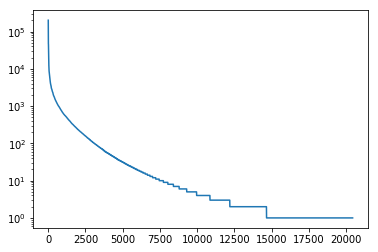

In [13]:
import matplotlib.pyplot as plt

def plotValues(values):
    fig, ax = plt.subplots()
    xs = range(len(values))
    ys = [x for x in values]
    ax.set_yscale('log')
    ax.plot(xs, ys)
    plt.savefig('result.png')
    plt.show()

plotValues([x[1] for x in order_terms])

In [9]:
def getPolSet():
    filename = '../polimorfologik-2.1/polimorfologik-2.1.txt'
    polSet = set()
    with open(filename, 'r', encoding="utf8") as content_file:
        for line in content_file.readlines():
            polSet.update(line.split(';'))
    return polSet

polSet = getPolSet()

In [16]:
[(k, v) for (k, v) in order_terms if k not in polSet][:30]

[('margin', 1111),
 ('późn', 1080),
 ('ue', 591),
 ('family', 543),
 ('text', 531),
 ('mso', 448),
 ('bottom', 399),
 ('face', 327),
 ('panose', 326),
 ('serif', 325),
 ('gmo', 298),
 ('times', 296),
 ('iv', 272),
 ('pkp', 272),
 ('sa', 266),
 ('name', 254),
 ('size', 248),
 ('ewg', 235),
 ('left', 233),
 ('right', 233),
 ('sww', 227),
 ('nbp', 214),
 ('efta', 204),
 ('skw', 196),
 ('ex', 169),
 ('height', 168),
 ('line', 168),
 ('ike', 162),
 ('vi', 154),
 ('polsce', 150)]

In [17]:
[(k, v) for (k, v) in order_terms if k not in polSet and v == 3][:30]

[('adaptacyjnoopiekuńcze', 3),
 ('agaricus', 3),
 ('apostille', 3),
 ('armenii', 3),
 ('asistent', 3),
 ('atenach', 3),
 ('auditorów', 3),
 ('aujeszky', 3),
 ('auschwitz', 3),
 ('autologicznego', 3),
 ('aw', 3),
 ('beliny', 3),
 ('betaagonistycznym', 3),
 ('betania', 3),
 ('białymstoku', 3),
 ('biorównoważności', 3),
 ('birkenau', 3),
 ('bochnia', 3),
 ('boguszów', 3),
 ('brucellosis', 3),
 ('cannabis', 3),
 ('caprine', 3),
 ('cattles', 3),
 ('cał', 3),
 ('cego', 3),
 ('chemiczn', 3),
 ('chloro', 3),
 ('cidr', 3),
 ('cobrpib', 3),
 ('condensed', 3)]

In [33]:
import editdistance

correct_words_ordered = [k for (k, v) in order_terms if k in polSet]
strange_3_words = [k for (k, v) in order_terms if k not in polSet and v == 3][:30]

for strange_word in strange_3_words:
    min_distance = float('inf')
    min_word = ''
    for correct_word in correct_words_ordered:
        distance = editdistance.eval(strange_word, correct_word)
        if min_distance > distance:
            min_distance = distance
            min_word = correct_word
    print(strange_word, min_word)

adaptacyjnoopiekuńcze adaptacyjny
agaricus awaria
apostille postulat
armenii karmienie
asistent asystent
atenach antena
auditorów audytor
aujeszky areszt
auschwitz uchwyt
autologicznego autonomiczny
aw aż
beliny celny
betaagonistycznym agonistyczny
betania brytania
białymstoku białostocki
biorównoważności równoważność
birkenau higiena
bochnia bocznica
boguszów poruszać
brucellosis bruceloza
cannabis napis
caprine curie
cattles atlas
cał cały
cego czego
chemiczn chemiczny
chloro chlor
cidr cydr
cobrpib obręb
condensed kontener
